<a href="https://colab.research.google.com/github/ukf-matusklestinec/Strojovy-preklad-DP/blob/main/Predspracovanie_dat_Trenovanie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# KORPUSY
# https://opus.nlpl.eu/Europarl/en&sk/v7/Europarl
# https://opus.nlpl.eu/ParaCrawl/en&sk/v9/ParaCrawl


# https://github.com/google/sentencepiece - SentencePiece
# https://opennmt.net/OpenNMT-tf/configuration.html - dokumentácia pre config

In [3]:
!pip install sentencepiece
!pip3 install OpenNMT-py
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.8/262.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 119.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=71c87ae8f920958cecc9ed7ea904b57b7bb87f642ff8da2e683e59aaad8f1d4b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce

In [4]:
import pandas as pd
import numpy as np
import csv
import sentencepiece as spm
import time
from langdetect import detect, LangDetectException, DetectorFactory  # pre identifikáciu jazykov
import unicodedata  # pre normalizáciu unicode

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import sacrebleu

In [ ]:
#en_parl = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.en"
#sk_parl = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.sk"

en_parl = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en"
sk_parl = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.sk"

#en_parl = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl_10/ParaCrawl.en"
#sk_parl = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl_10/ParaCrawl.sk"

# Filtrovanie/Čistenie korpusu

In [ ]:
# funkcia na výpis hodnôt ako čas, počet zmenených riadkov atď.
def print_status(operacia, pocet_riadkov, pocet_odst_riadkov, prejdeny_cas):
    print(f"{operacia} Riadky: {pocet_riadkov} | Odstránené riadky: {pocet_odst_riadkov} | Čas: {prejdeny_cas:.2f} sekúnd")

## Unicode normalizáca pre zistenie, aké znaky sa nachádzajú v našom korpuse

V prvotných pokusoch sa nachádzal v hlavnej časti predspracovania, ale v dôsledku neskorších zistení slúži skôr ako nástroj na zistenie špecifických znakov. Podľa zistení následne vieme vytvoriť pravidlá, ktoré upravia tieto znaky.

In [ ]:
start_time = time.time()

df_source = pd.read_csv(en_parl, names=['Source'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre anglický text (source)
df_target = pd.read_csv(sk_parl, names=['Target'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre slovenský text (target)
df = pd.concat([df_source, df_target], axis=1)
print("Rozmery datasetu (riadky, stĺpce):", df.shape)

# Konverzia na string a uloženie pôvodných hodnôt pred normalizáciou
original_source = df['Source'].astype(str)
original_target = df['Target'].astype(str)

# Unicode normalizácia
df['Source'] = df['Source'].astype(str).apply(lambda x: unicodedata.normalize('NFKC', x))
df['Target'] = df['Target'].astype(str).apply(lambda x: unicodedata.normalize('NFKC', x))

# Porovnanie pôvodných a normalizovaných hodnôt ako reťazcov a spočítanie zmenených riadkov
source_sum = (original_source != df['Source']).sum()
target_sum = (original_target != df['Target']).sum()

# Identifikácia riadkov, ktoré sa zmenili
source_zmena = original_source != df['Source']
target_zmena = original_target != df['Target']


riadky = 20 # aby nevypísalo veľmi veľké množsto textu

# Výpis zmenených viet pre Source (Anglické texty)
print("Príklady zmenených riadkov pre 'Source':")
for pred, po in zip(original_source[source_zmena][:riadky], df['Source'][source_zmena][:riadky]):
    print(f"Pred: {pred} | Po: {po}")

# Výpis zmenených viet pre Target (Slovenské texty)
print("\nPríklady zmenených riadkov pre 'Target':")
for pred, po in zip(original_target[target_zmena][:riadky], df['Target'][target_zmena][:riadky]):
    print(f"Pred: {pred} | Po: {po}")

prejdeny_cas = time.time() - start_time
print(f"\nNormalizácia na základe UNICODE znakov\t\t\t         Riadky: {df.shape[0]} | Počet zmenených riadkov v source (ANG): {source_sum} | Počet zmenených riadkov v target (SK): {target_sum} | Čas: {prejdeny_cas:.2f} sekúnd")

Rozmery datasetu (riadky, stĺpce): (640715, 2)
Príklady zmenených riadkov pre 'Source':
Pred: (The order of business was adopted¹) | Po: (The order of business was adopted1)
Pred: Dr Sean Barrett, a senior lecturer in economics at Trinity College Dublin, has today described the reduction of the corporation tax rate in Ireland from 50% in the 1980s to 12½% a decade later as 'the most important policy measure that achieved the transformation of Ireland'. | Po: Dr Sean Barrett, a senior lecturer in economics at Trinity College Dublin, has today described the reduction of the corporation tax rate in Ireland from 50% in the 1980s to 121⁄2% a decade later as 'the most important policy measure that achieved the transformation of Ireland'.
Pred: I agree that it is absolutely essential to avoid an increase of more than 2ºC in the global temperature, so as to avoid the most catastrophic scenarios, suggesting that the ambitious EU targets for the reduction of greenhouse gas emissions should be ma

In [ ]:
## Výpočet priemernej dĺžky vety a priemerného počtu slov

df_source = pd.read_csv(en_parl, names=['Source'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre anglický text (source)
df_target = pd.read_csv(sk_parl, names=['Target'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre slovenský text (target)
df = pd.concat([df_source, df_target], axis=1)
print("Rozmery datasetu (riadky, stĺpce):", df.shape)

df = df.dropna() # nutné odstránenie NaN hodnôt, aby fungoval zvyšný kód

df['Source_pocet_slov'] = df['Source'].apply(lambda x: len(x.split()))
df['Target_pocet_slov'] = df['Target'].apply(lambda x: len(x.split()))

# Vypočítanie priemerného množstva slov vo vetách
priem_pocet_slov_source = df['Source_pocet_slov'].mean()
priem_pocet_slov_target = df['Target_pocet_slov'].mean()

# Vypočítanie maximálneho množstva slov vo vetách
max_pocet_slov_source = df['Source_pocet_slov'].max()
max_pocet_slov_target = df['Target_pocet_slov'].max()


print("Priemerný počet slov vo vete (anglický text):", priem_pocet_slov_source)
print("Priemerný počet slov vo vete (slovenský text):", priem_pocet_slov_target)

print("Maximálny počet slov vo vete (anglický text):", max_pocet_slov_source)
print("Maximálny počet slov vo vete (slovenský text):", max_pocet_slov_target)

df['Source_dlzka_slova'] = df['Source'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
df['Target_dlzka_slova'] = df['Target'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

# Vypočínie priemernej dĺžky slov vo vetách
priem_dlzka_slov_source = df['Source_dlzka_slova'].mean()
priem_dlzka_slov_target = df['Target_dlzka_slova'].mean()

# Vypočítanie maximálnej dĺžky slova vo vetách
max_dlzka_slov_source = df['Source_dlzka_slova'].max()
max_dlzka_slov_target = df['Target_dlzka_slova'].max()

print("Priemerná dĺžka slova vo vete (anglický text):", priem_dlzka_slov_source)
print("Priemerná dĺžka slova vo vete (slovenský text):", priem_dlzka_slov_target)

print("Maximálna dĺžka slova vo vete (anglický text):", max_dlzka_slov_source)
print("Maximálnay dĺžka slova vo vete (slovenský text):", max_dlzka_slov_target)

Rozmery datasetu (riadky, stĺpce): (640715, 2)
Priemerný počet slov vo vete (anglický text): 24.12922803826525
Priemerný počet slov vo vete (slovenský text): 20.212435581307407
Maximálny počet slov vo vete (anglický text): 254
Maximálny počet slov vo vete (slovenský text): 219
Priemerná dĺžka slova vo vete (anglický text): 5.041560076423107
Priemerná dĺžka slova vo vete (slovenský text): 5.907997331197968
Maximálna dĺžka slova vo vete (anglický text): 21.0
Maximálnay dĺžka slova vo vete (slovenský text): 21.0


### Vytvorenie grafov

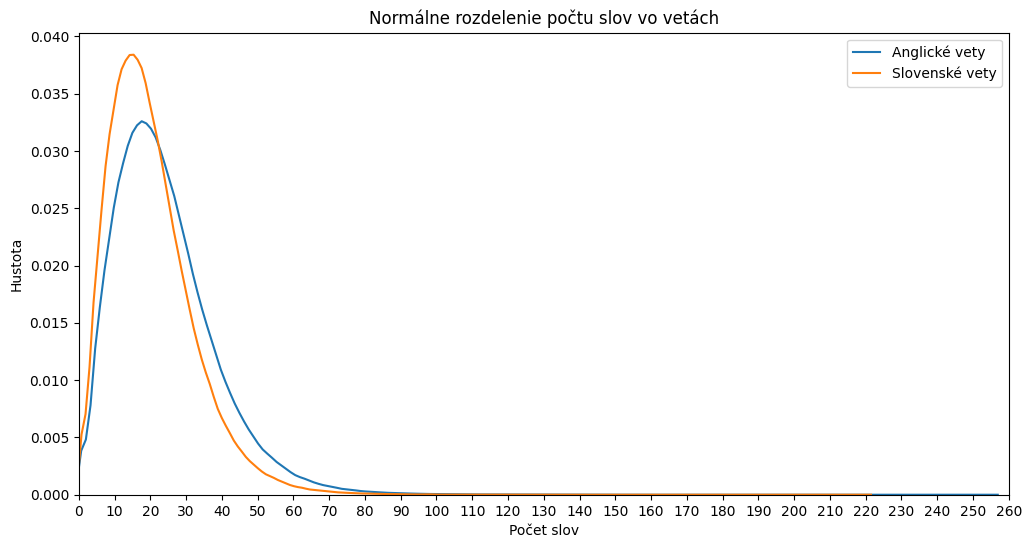

In [ ]:
# Graf normálneho rozdelenia počtu slov viet anglického a slovenského textu
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(df['Source_pocet_slov'], ax=ax, label="Anglické vety")
sns.kdeplot(df['Target_pocet_slov'], ax=ax, label="Slovenské vety")

ax.set_xlim(0, 250)
ax.set_xticks(range(0, 261, 10))

ax.set_title("Normálne rozdelenie počtu slov vo vetách")
ax.set_xlabel("Počet slov")
ax.set_ylabel("Hustota")
ax.legend()

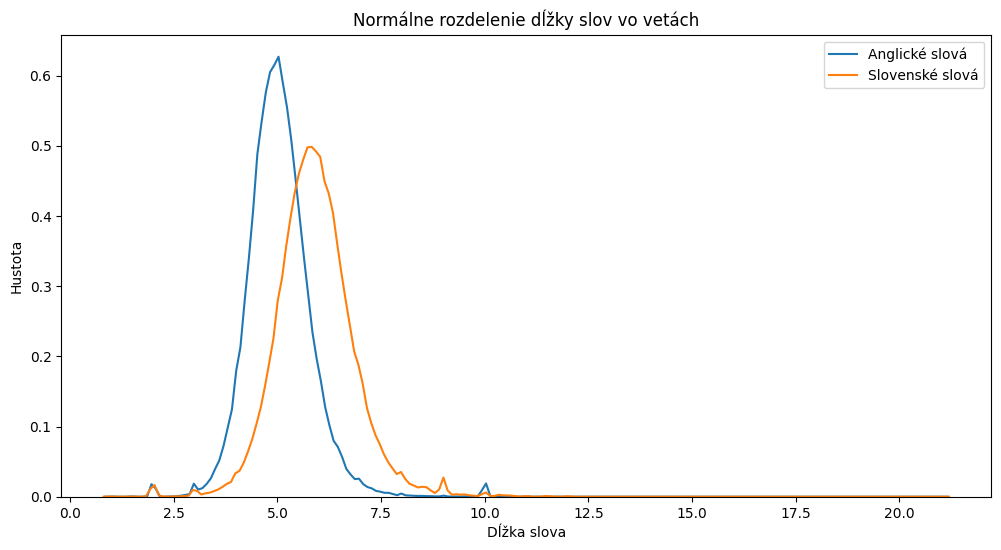

In [ ]:
# Graf normálneho rozdelenia dĺžky viet slov  anglického a slovenského textu
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(df['Source_dlzka_slova'], ax=ax, label="Anglické slová")
sns.kdeplot(df['Target_dlzka_slova'], ax=ax, label="Slovenské slová")

ax.set_title("Normálne rozdelenie dĺžky slov vo vetách")
ax.set_xlabel("Dĺžka slova")
ax.set_ylabel("Hustota")
ax.legend()

## Hlavné čistenie a úprava korpusu

In [ ]:
start_time = time.time()

df_source = pd.read_csv(en_parl, names=['Source'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre anglický text (source)
df_target = pd.read_csv(sk_parl, names=['Target'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False) # dataset pre slovenský text (target)
df = pd.concat([df_source, df_target], axis=1)

#df = df.iloc[:int(df.shape[0]/2),:] # rozdelenie na polku

print("Rozmery datasetu (riadky, stĺpce):", df.shape)


# Odstránenie NaN hodnôt
pocet_riadkov = df.shape[0]
df = df.dropna()
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Riadky bez NaN hodnôt\t\t\t\t\t        ", df.shape[0], odstranene_riadky, time.time() - start_time)


# Zmeny niektorých znakov, na základe zistení pomocou unicode normalizácie NFKC
pocet_riadkov = df.shape[0]

original_source = df['Source'] # budúca referencia ako počet zmenených znakov
original_target = df["Target"] # budúca referencia ako počet zmenených znakov

# Odstránenie exponentov, ktoré nie sú veďla čísel (väčšinou sa jedná o exponenty, ktoré referujú na zdroj, čo nie je žiadúce v našom modely) a zároveň sú dané slová dlhšie ako 3, aby sme omylom nevymazali znak pre miery ako napríklad km, m atď.
df['Source'] = df['Source'].str.replace(r'(\b\w{4,})\s*([¹²³⁴⁵⁶⁷⁸⁹⁰]+)', r'\1', regex=True)
df['Target'] = df['Target'].str.replace(r'(\b\w{4,})\s*([¹²³⁴⁵⁶⁷⁸⁹⁰]+)', r'\1', regex=True)

# Transformácia º (U+00BA) a ˚ (U+02DA) na  ̊ (U+030A) pre zjednotenie znaku stupňa
df['Source'] = df['Source'].str.replace('\u00BA', '\u030A')
df['Target'] = df['Target'].str.replace('\u00BA', '\u030A')
df['Source'] = df['Source'].str.replace('\u02DA', '\u030A')
df['Target'] = df['Target'].str.replace('\u02DA', '\u030A')

# Transformácia ½ (U+00BD) na ,5
df['Source'] = df['Source'].str.replace('\u00BD', ',5')
df['Target'] = df['Target'].str.replace('\u00BD', ',5')

# Porovnanie pôvodných a normalizovaných hodnôt ako reťazcov a spočítanie zmenených riadkov
source_sum = (original_source != df['Source']).sum()
target_sum = (original_target != df['Target']).sum()

prejdeny_cas = time.time() - start_time
print(f"Normalizácia na základe UNICODE znakov\t\t\t         Riadky: {df.shape[0]} | Počet zmenených riadkov v source (ANG): {source_sum} | Počet zmenených riadkov v target (SK): {target_sum} | Čas: {prejdeny_cas:.2f} sekúnd")


# Odstránenie riadkov kde sa riadok source rovná riadku target
pocet_riadkov = df.shape[0]
df = df[df['Source'] != df['Target']]
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Odstránenie riadkov, kde sa riadok source rovná riadku target\t", df.shape[0], odstranene_riadky, time.time() - start_time)


# Odstránenie duplikátov
pocet_riadkov = df.shape[0]
df = df.drop_duplicates()
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Odstránenie duplicitných/rovnakých riadkov\t\t\t", df.shape[0], odstranene_riadky, time.time() - start_time)


# Odstránenie v dôsledku príliš dlhých viet source/target
# Dĺžka, ktorá sa považuje za "príliš dlhú" záleží od jazyka
pocet_riadkov = df.shape[0]
max_sentence_length = 175
df = df[~((df['Source'].str.count(' ') > max_sentence_length) | (df['Target'].str.count(' ') > max_sentence_length))]
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Odstránenie príliš dlhých viet source/target\t\t        ", df.shape[0], odstranene_riadky, time.time() - start_time)


# konverzia špeciálnych (HTML) znakov
pocet_riadkov = df.shape[0]

df['Source'] = df['Source'].str.replace(r'&amp;', '&', regex=True)
df['Source'] = df['Source'].str.replace(r'&quot;', '"', regex=True)
df['Source'] = df['Source'].str.replace(r'&apos;', '\'', regex=True)
df['Source'] = df['Source'].str.replace(r'&lt;', '<', regex=True)
df['Source'] = df['Source'].str.replace(r'&gt;', '>', regex=True)

df['Target'] = df['Target'].str.replace(r'&amp;', '&', regex=True)
df['Target'] = df['Target'].str.replace(r'&quot;', '"', regex=True)
df['Target'] = df['Target'].str.replace(r'&apos;', '\'', regex=True)
df['Target'] = df['Target'].str.replace(r'&lt;', '<', regex=True)
df['Target'] = df['Target'].str.replace(r'&gt;', '>', regex=True)

odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Konverzia HTML znakov\t\t\t\t        	", df.shape[0], odstranene_riadky, time.time() - start_time)

# Odstránenie znakov, ktoré nie sú písmená/čísla
#df['Source'] = df['Source'].str.replace(r'(?<![,\d])[^,\w\s¹²³⁴⁵⁶⁷⁸⁹⁰\u030A-]+', '', regex=True) # kód ponecháva čiarky pred číslami, exponenty čísel, znak stupňa a pomlčky a samozrejme písmená a čísla.
#df['Target'] = df['Target'].str.replace(r'(?<![,\d])[^,\w\s¹²³⁴⁵⁶⁷⁸⁹⁰\u030A-]+', '', regex=True)

df['Source'] = df['Source'].str.replace('[^\w\s]', '', regex=True)
df['Target'] = df['Target'].str.replace('[^\w\s]', '', regex=True)

odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Odstránenie znakov, ktoré nie sú písmená/čísla\t\t\t", df.shape[0], odstranene_riadky, time.time() - start_time)

# konverzia na malé písmená
pocet_riadkov = df.shape[0]
#df['Source'] = df['Source'].apply(lambda x: x[:1].lower() + x[1:])
#df['Target'] = df['Target'].apply(lambda x: x[:1].lower() + x[1:])

df['Source'] = df['Source'].str.lower()
df['Target'] = df['Target'].str.lower()


prejdeny_cas = time.time() - start_time
odstranene_riadky = pocet_riadkov - df.shape[0] # tu je to len, aby to pasovalo pre funkciu print_status
print_status("Riadky sú konvertované na malé písmená (lowercase)\t\t", df.shape[0], odstranene_riadky, time.time() - start_time)


# Nahradenie prázdnych riadkov NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Dodatočné odstránenie riadkov, kde je NaN, ktoré mohli vzniknúť v dôsledku minulých krokov
pocet_riadkov = df.shape[0]
df = df.dropna()
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Riadky bez NaN hodnôt\t\t\t\t\t        ", df.shape[0], odstranene_riadky, time.time() - start_time)

# kontrola jazyka - tento proces trvá najdlhšie
def kontrola(text):
    try:
        return detect(text)
    except LangDetectException:
        return None

pocet_riadkov = df.shape[0]
DetectorFactory.seed = 0 # pridanie seed, aby sme vždy dostali rovnaký výsledok, keďže langdetect algoritmus je nedeterministický, čiže v niektorých prípadoch môže rozhodnúť odlišne

df['source_jazyk'] = df['Source'].apply(lambda x: kontrola(x) if x and len(x.split()) > 1 else None) # ak obsahuje veta len jedno slovo, nevykoná sa nič
df['target_jazyk'] = df['Target'].apply(lambda x: kontrola(x) if x and len(x.split()) > 1 else None)

df = df[(df['source_jazyk'] == "en") & (df['target_jazyk'] == "sk")]
df.drop(columns=['source_jazyk', 'target_jazyk'], inplace=True)
odstranene_riadky = pocet_riadkov - df.shape[0]
print_status("Kontrola jazykov\t\t\t\t\t        ", df.shape[0], odstranene_riadky, time.time() - start_time)


# Zmenenie poradia riadkov
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # pridanie random_state, aby sme dostali vždy rovnako zamiešaný dataset
print("Prehodenie poradia riadkov\t\t\t\t\t Riadky:", df.shape[0])

prejdeny_cas = time.time() - start_time
print(f"Celkový prejdený čas: {prejdeny_cas:.2f} sekúnd")

source_subor = en_parl+'-filtered.'+ "en"
target_subor = sk_parl+'-filtered.'+ "sk"

df_source_en = df["Source"]
df_target_sk = df["Target"]

df_source_en.to_csv(source_subor, header=False, index=False, quoting=csv.QUOTE_NONE, sep="\n")
print("Source súbor uložený:", source_subor)
df_target_sk.to_csv(target_subor, header=False, index=False, quoting=csv.QUOTE_NONE, sep="\n")
print("Target súbor uložený:", target_subor)

Rozmery datasetu (riadky, stĺpce): (640715, 2)
Riadky bez NaN hodnôt					         Riadky: 640703 | Odstránené riadky: 12 | Čas: 2.78 sekúnd
Normalizácia na základe UNICODE znakov			         Riadky: 640703 | Počet zmenených riadkov v source (ANG): 109 | Počet zmenených riadkov v target (SK): 116 | Čas: 12.87 sekúnd
Odstránenie riadkov, kde sa riadok source rovná riadku target	 Riadky: 640703 | Odstránené riadky: 0 | Čas: 13.10 sekúnd
Odstránenie duplicitných/rovnakých riadkov			 Riadky: 640703 | Odstránené riadky: 0 | Čas: 13.86 sekúnd
Odstránenie príliš dlhých viet source/target		         Riadky: 640703 | Odstránené riadky: 0 | Čas: 15.78 sekúnd
Konverzia HTML znakov				        	 Riadky: 640703 | Odstránené riadky: 0 | Čas: 19.70 sekúnd
Odstránenie znakov, ktoré nie sú písmená/čísla			 Riadky: 640703 | Odstránené riadky: 0 | Čas: 23.00 sekúnd
Riadky sú konvertované na malé písmená (lowercase)		 Riadky: 640703 | Odstránené riadky: 0 | Čas: 23.74 sekúnd
Riadky bez NaN hodnôt					        

<ipython-input-7-57ea072be3e4>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['source_jazyk', 'target_jazyk'], inplace=True)


Kontrola jazykov					         Riadky: 512176 | Odstránené riadky: 128527 | Čas: 8442.16 sekúnd
Prehodenie poradia riadkov					 Riadky: 512176
Celkový prejdený čas: 8442.36 sekúnd
Source súbor uložený: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en-filtered.en
Target súbor uložený: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.sk-filtered.sk


# Tokenizácia na subwordy

In [5]:
en_filt = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.en-filtered.en"
sk_filt = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.sk-filtered.sk"

#en_filt = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.en-filtered.en"
#sk_filt = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/ParaCrawl.sk-filtered.sk"

In [6]:
#https://github.com/google/sentencepiece


#Parametre
vocab_size = 8000
character_coverage = 0.9995

# pre prípad veľkých korpusov -> --train_extremely_large_corpus=false

# Model pre tokenizáciu anglického textu (source) na subword
source = f'--input={en_filt} --model_prefix=source --vocab_size={vocab_size} --hard_vocab_limit=false --character_coverage={character_coverage} --split_digits=true --model_type=bpe'
spm.SentencePieceTrainer.train(source)
print("Trénovanie SentencePiece modelu bolo pre source súbor dokončené")


# Model pre tokenizáciu slovenského textu (target) na subword
target = f'--input={sk_filt} --model_prefix=target --vocab_size={vocab_size} --hard_vocab_limit=false --character_coverage={character_coverage} --split_digits=true --model_type=bpe'
spm.SentencePieceTrainer.train(target)
print("Trénovanie SentencePiece modelu bolo pre target súbor dokončené")

Trénovanie SentencePiece modelu bolo pre source súbor dokončené
Trénovanie SentencePiece modelu bolo pre target súbor dokončené


In [7]:
source_model = r"/content/source.model"
target_model = r"/content/target.model"
source_subworded = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded"
target_subworded = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded"

#source_subworded = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded"
#target_subworded = "/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded"

In [8]:
def subwordovanie(sp, vstup, vystup, interval=100000):
    try:
        with open(vstup, encoding="utf-8") as vstup, open(vystup, "w+", encoding="utf-8") as vystup:
            for i, rad in enumerate(vstup):
                rad = rad.strip()
                token = sp.encode_as_pieces(rad)
                vystup.write(" ".join(token) + "\n")

                if (i + 1) % interval == 0:
                    print(f"Spracovaných {i + 1} riadkov v {vstup}")
    except Exception as e:
        print(f"Nastala chyba v procese {vstup}: {e}")

sp = spm.SentencePieceProcessor()

sp.load(source_model)
subwordovanie(sp, en_filt, source_subworded)
print(f"Subwordovanie Source súboru bolo dokončené: {source_subworded}")

sp.load(target_model)
subwordovanie(sp, sk_filt, target_subworded)
print(f"Subwordovanie Target súboru bolo dokončené: {target_subworded}")

Spracovaných 100000 riadkov v <_io.TextIOWrapper name='/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.en-filtered.en' mode='r' encoding='utf-8'>
Spracovaných 200000 riadkov v <_io.TextIOWrapper name='/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.en-filtered.en' mode='r' encoding='utf-8'>
Spracovaných 300000 riadkov v <_io.TextIOWrapper name='/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.en-filtered.en' mode='r' encoding='utf-8'>
Subwordovanie Source súboru bolo dokončené: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded
Spracovaných 100000 riadkov v <_io.TextIOWrapper name='/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.sk-filtered.sk' mode='r' encoding='utf-8'>
Spracovaných 200000 riadkov v <_io.TextIOWrapper name='/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.sk-filtered.sk' mode='r' en

# Tokenizácia na slová

In [ ]:
import pyonmttok
import pickle

In [ ]:
en_filt = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.en-filtered.en"
sk_filt = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/europarl.sk-en.sk-filtered.sk"

In [ ]:
en_tokenizer = pyonmttok.Tokenizer("conservative")
sk_tokenizer = pyonmttok.Tokenizer("conservative")

# tokenizácia anglického textu
with open(en_filt, "r", encoding="utf-8") as en_file:
    en_content = en_file.read()
    en_tokens, _ = en_tokenizer.tokenize(en_content)

# tokenizácia slovenského textu
with open(sk_filt, "r", encoding="utf-8") as sk_file:
    sk_content = sk_file.read()
    sk_tokens, _ = sk_tokenizer.tokenize(sk_content)

# uloženie súborov
en_token_slov = "/content/en_token_slova.csv"
sk_token_slov = "/content/sk_token_slova.csv"

with open(en_token_slov, "w", newline="", encoding="utf-8") as en_csv:
    writer = csv.writer(en_csv)
    writer.writerow(en_tokens)

with open(sk_token_slov, "w", newline="", encoding="utf-8") as sk_csv:
    writer = csv.writer(sk_csv)
    writer.writerow(sk_tokens)

print("Tokenizácia na slová bola dokončená pre oba jazyky.")

Tokenizácia na slová bola dokončená pre oba jazyky.


In [ ]:
source_subor = r"/content/en_token_slova.csv"
target_subor = r"/content/sk_token_slova.csv"

In [ ]:
with open(source_subor, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

with open(target_subor, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Výpis riadkov súboru

In [9]:
with open(source_subworded, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

with open(target_subworded, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

▁we ▁share ▁your ▁view ▁on ▁that ▁point
▁this ▁is ▁a ▁reference ▁to ▁the ▁ Y am al - Europe ▁natural ▁gas ▁pipeline ▁and ▁the ▁F ri ends hip ▁oil ▁pipeline
▁we ▁in ▁Europe ▁realise ▁that ▁rest oring ▁the ▁financial ▁markets ▁to ▁normal ▁conditions ▁of ▁operation ▁depends ▁largely ▁on ▁the ▁American ▁financial ▁market ▁returning ▁to ▁normal
▁i ▁am ▁really ▁more ▁than ▁glad ▁to ▁see ▁that ▁Mr ▁M lad en ov s ▁report ▁is ▁doing ▁this ▁through ▁the ▁good ▁set - up ▁of ▁the ▁pie ces ▁of ▁his ▁work ▁and ▁also ▁has ▁such ▁n ice ▁and ▁meaning ful ▁support ▁from ▁his ▁colleagues
▁author ▁- ▁ES ▁Mr ▁President , ▁the ▁human ▁rights ▁situation ▁in ▁Iran ▁has ▁deterior ated ▁dram atically ▁since ▁ 2 0 0 5 .
▁the ▁Council ▁will ▁consider ▁the ▁EUs ▁negotiating ▁stance ▁for ▁the ▁Copenhagen ▁climate ▁conference

▁na ▁tento ▁bod ▁máme ▁rovnaký ▁názor ▁ako ▁vy
▁toto ▁je ▁odkaz ▁na ▁plynovod ▁J am al ▁- ▁Európa ▁a ▁ro pov od u ▁D ru ž ba
▁v ▁Európe ▁si ▁uvedomujeme , ▁že ▁obnov a ▁finančných ▁trhov ▁späť

# Rozdelenie dát na množiny

Dáta rozdelujeme do 3 častí:

    trénovací dataset - používa sa na trénovanie modelu;
    development (validačný) dataset - používa sa na validáciu modelu počas trénovania, aby sa mohli vylepšiť parametre modelu
    testovací dataset - používa sa na konečné vyhodotenie (evaluáciu) modelu na modelom nevidených dátach

In [10]:
source_subor = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded"
target_subor = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded"


#source_subor = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded"
#target_subor = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded"

In [11]:
# Veľkosť súborov pre dev a test text
dataset_velkost = 2000

development = dataset_velkost
test = dataset_velkost


def train_test_dev(development, test, source_subor, target_subor):
    df_source = pd.read_csv(source_subor, names=['Source'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False, encoding="utf-8")
    df_target = pd.read_csv(target_subor, names=['Target'], sep="\0", quoting=csv.QUOTE_NONE, skip_blank_lines=False, encoding="utf-8")
    df = pd.concat([df_source, df_target], axis=1)

    # Odstránenie prázdnych riadkov
    df.dropna(inplace=True)

    # Zamiešanie datasetu
    df = df.sample(frac=1, random_state=42).reset_index(drop=True) # pridanie random_state, aby sme dostali vždy rovnako zamiešaný dataset

    # Rozdelenie datasetu
    df_dev = df[:development]
    df_test = df[development:development + test]
    df_train = df[development + test:]

    def vytvorenie_suboru(df, source_subor, target_subor):
        df['Source'].to_csv(source_subor, index=False, header=False, quoting=csv.QUOTE_NONE, sep='\n')
        df['Target'].to_csv(target_subor, index=False, header=False, quoting=csv.QUOTE_NONE, sep='\n')


    vytvorenie_suboru(df_train, source_subor + '.train', target_subor + '.train')
    vytvorenie_suboru(df_dev, source_subor + '.dev', target_subor + '.dev')
    vytvorenie_suboru(df_test, source_subor + '.test', target_subor + '.test')


train_test_dev(development, test, source_subor, target_subor)

In [12]:
source_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.test"
target_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.test"

#source_test = r"/content/en_token_slova.csv.test"
#target_test = r"/content/sk_token_slova.csv.test"

#source_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded.test"
#target_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.test"

In [13]:
with open(source_test, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

with open(target_test, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

▁i ▁have ▁caused ▁some ▁en quir ies ▁to ▁be ▁made ▁and ▁my ▁first ▁point ▁would ▁be ▁that ▁we ▁are ▁dealing ▁with ▁ Q uestion ▁Time ▁to ▁the ▁Commission , ▁not ▁to ▁a ▁particular ▁Commissioner
▁he ▁served ▁as ▁President ▁of ▁the ▁European ▁Commission ▁from ▁ 1 9 8 1 ▁until ▁ 1 9 8 5 .
▁in ▁writing ▁- ▁IT ▁Madam ▁President , ▁ladies ▁and ▁gentlemen , ▁I ▁voted ▁in ▁favour ▁of ▁Mrs ▁T o ias ▁report ▁on ▁the ▁social ▁economy
▁we ▁want ▁a ▁judicial ▁res ervation , ▁a ▁judicial ▁decision ▁on ▁fundamental ▁rights
▁for ▁example , ▁desertification ▁may ▁inten sify ▁an ▁existing ▁general ▁cl im atic ▁tend ency ▁towards ▁greater ▁d ry ness , ▁or ▁it ▁may ▁initially ▁arise ▁from ▁a ▁change ▁in ▁the ▁local ▁climate
▁i ▁would ▁like ▁to ▁remind ▁the ▁Commissioner ▁and ▁the ▁President ▁that ▁the ▁European ▁Parliament ▁has ▁already ▁expressed ▁its ▁support , ▁by ▁a ▁large ▁majority , ▁on ▁this ▁issue

▁dala ▁som ▁zistiť ▁niekoľko ▁informácií ▁a ▁moja ▁prvá ▁pripomien ka ▁je , ▁že ▁v ▁otázky ▁vo ▁vyh r

# Vytvorenie konfigurácie a trénovanie modelu

In [ ]:
config = '''

seed: 42 # aby sme dosiahli rovnakých výsledkov a pre lepšie porovnávanie medzi modelmi

save_data: vocab  # zložka, kde sa uloží slovná zásoba vygenerovaná pomocou onmt_build_vocab

data:
    corpus:
        # súbory určené na trénovanie
        path_src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.train
        path_tgt: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.train

        #path_src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded.train
        #path_tgt: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.train
        transforms: [filtertoolong]
        weight: 1
    valid:
        # súbory určené na validáciu
        path_src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.dev
        path_tgt: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.dev

        #path_src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded.dev
        #path_tgt: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.dev
        transforms: [filtertoolong]

# súbory, v ktorých je uložená slovná zásoba pre source (anglický jazyk) a target (slovenský jazyk) onmt_build_vocab
src_vocab: vocab/source.vocab
tgt_vocab: vocab/target.vocab

# veľkosť slovnej zásoby - hodnoty by mali byť rovnaké ako v sentencepiece
src_vocab_size: 8000
tgt_vocab_size: 8000

src_subword_model: /content/source.model
tgt_subword_model: /content/target.model

# Miesto uloženia súborov
#log_file:   /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/train.log
save_model: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/complete_model

#save_model: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/complete_model

train_steps: 100000 # počet krokov trénovania
valid_steps: 2500  # po n krokoch vykonať validáciu pomocou dev setu
warmup_steps: 8000 # počet by mal byť priamoúmerný počtu krokov trénovania
early_stopping: 4 # ak sa model nezlepší po n validáciach, trénovanie zastaví
save_checkpoint_steps: 2500   # uloženie modelu po n krokoch
keep_checkpoint: 15  # počet posledných n uložených modelov
report_every: 500 # výpis informácií o trénovaní po n-krokoch

decoder_type: transformer
encoder_type: transformer
word_vec_size: 512   # dimenzionálnosť word embeddingu
hidden_size: 512     # dimenzionálnosť skrytých stavov v enkódery a dekódery
layers: 6         # počet vrstiev v enkódery a dekódery   - alternatíva je enc_layers a dec_layers
transformer_ff: 2048  # dimenzionálnosť doprednej vrstvy v transformery
heads: 8              # počet attention head v multi-head-attention

accum_count: 2 # počet n krokov, po ktorých sa aktualizujú parametre
optim: adam
adam_beta1: 0.9
adam_beta2: 0.998
decay_method: noam
learning_rate: 2.0  # miera učenia
max_grad_norm: 1.0    # gradient clipping, pomáha, aby v modely nenastal explodujúci gradient (nemožnosť modelu sa učiť v dôsledku vysokej miery učenia), emôže pomôcť pre lepšiu stabilitu modelu

param_init: 0.0
param_init_glorot: 'true'
position_encoding: 'true'

batch_size: 1024
valid_batch_size: 1024
batch_type: tokens
normalization: tokens
max_generator_batches: 2

dropout: 0.1         # regularizácia, ktorá vytvára šancu (0.1 = 10%) na "vypnutie" nodu vo vrstve behom trénovania, pomáha proti overfittingu
label_smoothing: 0.1

world_size: 1
gpu_ranks: 0

# INFO
log_file: train.log
log_level: INFO

'''

with open("config.yaml", "w+", encoding="utf-8") as config_yaml:
  config_yaml.write(config)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e28c12a8-d468-9c0d-db81-f55bb7da1397)


Použíjeme Framework OpenNMT

In [ ]:
# Vytvorenie vocabulary
!onmt_build_vocab -config config.yaml -n_sample -1

[2024-03-20 18:21:38,595 INFO] Counter vocab from -1 samples.
[2024-03-20 18:21:38,595 INFO] n_sample=-1: Build vocab on full datasets.
[2024-03-20 18:22:10,695 INFO] * Transform statistics for corpus(100.00%):
			* FilterTooLongStats(filtered=46)

[2024-03-20 18:22:10,718 INFO] Counters src: 8135
[2024-03-20 18:22:10,718 INFO] Counters tgt: 8117


In [ ]:
# Trénovanie the NMT model
!onmt_train -config config.yaml -gpu_ranks 0

[2024-03-20 18:22:15,044 INFO] Parsed 2 corpora from -data.
[2024-03-20 18:22:15,044 INFO] Get special vocabs from Transforms: {'src': [], 'tgt': []}.
[2024-03-20 18:22:15,076 INFO] The first 10 tokens of the vocabs are:['<unk>', '<blank>', '<s>', '</s>', '▁the', ',', '▁of', '▁to', '▁and', '▁in']
[2024-03-20 18:22:15,076 INFO] The decoder start token is: <s>
[2024-03-20 18:22:15,076 INFO] Building model...
[2024-03-20 18:22:16,766 INFO] Switching model to float32 for amp/apex_amp
[2024-03-20 18:22:16,766 INFO] Non quantized layer compute is fp32
[2024-03-20 18:22:17,197 INFO] NMTModel(
  (encoder): TransformerEncoder(
    (embeddings): Embeddings(
      (make_embedding): Sequential(
        (emb_luts): Elementwise(
          (0): Embedding(8000, 768, padding_idx=1)
        )
        (pe): PositionalEncoding()
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiHeadedAttention(
  

# Preklad

In [362]:
config_translate = '''

model: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/complete_model_step_85000.pt     # sem vložiť najlepší model trénovania
src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.test
output: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated

#model: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/complete_model_step_100000.pt     # sem vložiť najlepší model trénovania
#src: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/source_subworded.test
#output: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/translated

log_file: translate.log

seed: 42

beam_size: 10
min_length: 1
length_penalty: avg

batch_size: 32
batch_type: sents # default hodnota

gpu: 0

coverage_penalty: summary
beta: 0.0
alpha: 1.0 # default hodnota

'''

with open("config_translated.yaml", "w+", encoding="utf-8") as config_yaml:
  config_yaml.write(config_translate)

In [363]:
# Preklad
!onmt_translate -config config_translated.yaml

[2024-03-25 18:53:07,434 INFO] Loading checkpoint from /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/complete_model_step_85000.pt
[2024-03-25 18:53:08,565 INFO] Loading data into the model
/usr/local/lib/python3.10/dist-packages/onmt/translate/beam_search.py:493: UserWarning: Non-default coverage penalty with beta==0 is equivalent to using coverage penalty none.
  warnings.warn(
[2024-03-25 18:53:48,942 INFO] PRED SCORE: -0.3172, PRED PPL: 1.37 NB SENTENCES: 2000
Time w/o python interpreter load/terminate:  41.528825521469116


In [364]:
translated = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated"
#translated = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/translated"
with open(translated, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

▁spôsob il ▁mi ▁niekoľko ▁otázok , ▁ktoré ▁je ▁potrebné ▁urobiť , ▁a ▁moj im ▁prvým ▁bodom ▁je , ▁že ▁sa ▁zaoberáme ▁hod inou ▁otázok ▁Komisii ▁a ▁nie ▁konkrét nym ▁komisár om
▁slú žil ▁ako ▁predseda ▁Európskej ▁komisie ▁od ▁roku ▁ 1 9 8 1 ▁do ▁roku ▁ 1 9 8 5 .
▁vážená ▁pani ▁predsedajúca , ▁dámy ▁a ▁páni , ▁hlasoval ▁som ▁za ▁správu ▁pani ▁To ia ovej ▁o ▁sociál nom ▁hospodárstve
▁chceme ▁súd nu ▁vý hra du , ▁súd ne ▁rozhodnutie ▁o ▁základných ▁právach
▁napríklad ▁rozšir ovanie ▁p ú šte ▁môže ▁zintenzív niť ▁existujúce ▁všeobecné ▁klimatické ▁ten d encie ▁smerom ▁k ▁väčšej ▁su ch e , ▁alebo ▁môže ▁vznik núť ▁spo čia tku ▁z ▁zmeny ▁v ▁miestnej ▁kl íme
▁rád ▁by ▁som ▁pripomenul ▁pánovi ▁komisárovi ▁a ▁predsedovi , ▁že ▁Európsky ▁parlament ▁už ▁v ▁tejto ▁otázke ▁veľkou ▁väčšinou ▁vyjadril ▁svoju ▁podporu



In [365]:
target_model = r"/content/target.model"
translation = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated"
#translation = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/translated"
translation_desubword = translation + ".desubword"

sp = spm.SentencePieceProcessor()
sp.load(target_model)

# Desubword prekladový súbor
with open(translation, encoding='utf-8') as vstup, open(translation_desubword, "w", encoding='utf-8') as vystup:
    for rad in vstup:
        desub = sp.decode_pieces(rad.strip().split(" "))
        vystup.write(desub + "\n")

print(f"Dekódovanie bolo dokončené! Výstupný súbor: {translation_desubword}")

target_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.test"
#target_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.test"
target_test_desubword = target_test + ".desubword"

with open(target_test, encoding='utf-8') as vstup, open(target_test_desubword, "w", encoding='utf-8') as vystup:
    for rad in vstup:
        desub = sp.decode_pieces(rad.strip().split(" "))
        vystup.write(desub + "\n")

print(f"Dekódovanie bolo dokončené! Výstupný súbor: {target_test_desubword}")


source_test = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.test"
source_test_desubword = source_test + ".desubword"

with open(source_test, encoding='utf-8') as vstup, open(source_test_desubword, "w", encoding='utf-8') as vystup:
    for rad in vstup:
        desub = sp.decode_pieces(rad.strip().split(" "))
        vystup.write(desub + "\n")

print(f"Dekódovanie bolo dokončené! Výstupný súbor: {source_test_desubword}")

Dekódovanie bolo dokončené! Výstupný súbor: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated.desubword
Dekódovanie bolo dokončené! Výstupný súbor: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.test.desubword
Dekódovanie bolo dokončené! Výstupný súbor: /content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.test.desubword


In [366]:
reference = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.test.desubword"
preklad = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated.desubword"
zdroj = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.test.desubword"

#reference = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/target_subworded.test.desubword"
#preklad = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/ParaCrawl/translated.desubword"

In [367]:
with open(reference, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

dala som zistiť niekoľko informácií a moja prvá pripomienka je, že v otázky vo vyhradenom čase sú pre Komisiu a nie pre konkrétneho komisára
od roku 1981 až do roku 1985 vykonával funkciu predsedu Európskej komisie
vážená pani predsedajúca, dámy a páni, hlasoval som za správu pani Toiaovej o sociálnom hospodárstve
chceme súdnu výhradu, súdne rozhodnutie o základných právach
napríklad rozširovanie púšte môže zintenzívniť existujúci klimatický trend k väčšiemu suchu alebo sa tento proces môže spustiť z dôvodu zmeny miestnej klímy
chcel by som pripomenúť pani komisárke a úradujúcemu predsedovi, že Európsky parlament už vyjadril svoju podporu tejto otázke veľkou väčšinou



In [368]:
with open(preklad, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

spôsobil mi niekoľko otázok, ktoré je potrebné urobiť, a mojim prvým bodom je, že sa zaoberáme hodinou otázok Komisii a nie konkrétnym komisárom
slúžil ako predseda Európskej komisie od roku 1981 do roku 1985.
vážená pani predsedajúca, dámy a páni, hlasoval som za správu pani Toiaovej o sociálnom hospodárstve
chceme súdnu výhradu, súdne rozhodnutie o základných právach
napríklad rozširovanie púšte môže zintenzívniť existujúce všeobecné klimatické tendencie smerom k väčšej suche, alebo môže vzniknúť spočiatku z zmeny v miestnej klíme
rád by som pripomenul pánovi komisárovi a predsedovi, že Európsky parlament už v tejto otázke veľkou väčšinou vyjadril svoju podporu



In [369]:
with open(zdroj, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:
            break

print()

i▁have▁caused▁some enquiries to be▁made▁and my▁first▁point▁would be▁that▁we▁are▁dealing▁with Question▁Time to▁the▁Commission,▁not to a▁particular▁Commissioner
▁he▁served as▁President▁of▁the▁European▁Commission▁from 1981▁until 1985.
in▁writing - IT▁Madam▁President,▁ladies▁and▁gentlemen, I▁voted in▁favour▁of▁Mrs Toias▁report on▁the▁social▁economy
▁we▁want a▁judicial▁reservation, a▁judicial▁decision on▁fundamental▁rights
for▁example,▁desertification▁may▁intensify an▁existing▁general▁climatic▁tendency▁towards▁greater dryness,▁or▁it▁may▁initially▁arise▁from a▁change in▁the▁local▁climate
i▁would▁like to▁remind▁the▁Commissioner▁and▁the▁President▁that▁the▁European▁Parliament▁has▁already▁expressed▁its▁support, by a▁large▁majority, on▁this▁issue



# Evalvácia

In [370]:

#!python -m spacy download xx_ent_wiki_sm

#!pip install --upgrade pip
#!pip install unbabel-comet
#!pip install spacy

In [371]:
import spacy
import sacrebleu
from nltk.translate import meteor_score as ms
import nltk
import warnings
from comet import download_model, load_from_checkpoint
nltk.download('wordnet')

nlp = spacy.load("xx_ent_wiki_sm") #https://github.com/explosion/spacy-models/releases/tag/xx_ent_wiki_sm-3.7.0

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [372]:
reference = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.test.desubword"
preklad = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated.desubword"
zdroj = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.test.desubword"

In [373]:
# referenčné hodnoty
refer = []

with open(reference, encoding='utf-8') as reference:
    for rad in reference:
        rad = rad.strip()
        refer.append(rad)

print("Referenčná veta v SK jazyku:", refer[0]) # výpis prvej referenčenj vety, pomocou ktorej budeme porovnávať vety

refer = [refer]  # list listov, teda forma, ktorú si vyžaduje SacreBLEU

# hodnoty, ktoré sme preložili
prek = []

with open(preklad, encoding='utf-8') as preklad:
    for rad in preklad:
        rad = rad.strip()
        prek.append(rad)

print("Preložená veta:\t\t    ", prek[0]) # výpis prvého preloženého riadka

# BLEU skóre - výpočet BLEU na základe porovnania referenčných viet s preloženými vetami
bleu = sacrebleu.corpus_bleu(prek, refer)
print("BLEU:  ", bleu.score)

# tokenizácia je potrebná pre rozdelenie viet do menších častí (tokenov), aby Meteor dokázal porovnávať slová a ich význam
def tokenizacia(text):
    doc = nlp(text)
    return [token.text for token in doc]

meteor_scores = []
for refer_segment, prek in zip(refer, prek):
    ref = refer_segment[0]
    token_ref = tokenizacia(ref) # tokenizácia referenčných viet
    token_prek = tokenizacia(prek) # tokenizáci preložených viet

    # Výpočet METEOR skóre - meteor skóre narozdiel od bleu zohľadnuje sémantiku do istej miery
    score = ms.meteor_score([token_ref], token_prek) # výpočet meteor skóre pre jednu vetu
    meteor_scores.append(score)

average_meteor_score = sum(meteor_scores) / len(meteor_scores) # výpočet priemeru Meteor skóre, pre celú množinu preložených viet
print("METEOR: ", average_meteor_score)

Referenčná veta v SK jazyku: dala som zistiť niekoľko informácií a moja prvá pripomienka je, že v otázky vo vyhradenom čase sú pre Komisiu a nie pre konkrétneho komisára
Preložená veta:		     spôsobil mi niekoľko otázok, ktoré je potrebné urobiť, a mojim prvým bodom je, že sa zaoberáme hodinou otázok Komisii a nie konkrétnym komisárom
BLEU:   34.134509228151266
METEOR:  0.2528660866737133


In [374]:
# Výpočet COMET

model_comet = download_model("Unbabel/wmt22-comet-da")
model = load_from_checkpoint(model_comet)


def nacitanie(subor):
    with open(subor, "r", encoding="utf-8") as subor:
        text = subor.read()
    return text

zdroj = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/source_subworded.test.desubword"
preklad = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/translated.desubword"
reference = r"/content/drive/MyDrive/Colab_Notebooks/Diplomovka/Dáta/europarl/target_subworded.test.desubword"

# Načítanie textov zo súborov
zdroj_text = nacitanie(zdroj)
preklad_text = nacitanie(preklad)
reference_text = nacitanie(reference)

# Rozdelenie textov na vety
zdroj_vety = zdroj_text.split("\n")
preklad_vety = preklad_text.split("\n")
reference_vety = reference_text.split("\n")

# Predspracovanie dát do vhodnej podoby
data = [{"src": zdroj, "mt": preklad, "ref": reference} for zdroj, preklad, reference in zip(zdroj_vety, preklad_vety, reference_vety)]

# Výpočet COMET skóre
comet_skore = model.predict(data, batch_size=8, gpus=1)
print(comet_skore)



Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoade

Prediction([('scores', [0.6759707927703857, 0.9641156792640686, 0.9702885746955872, 0.9875921607017517, 0.8713369965553284, 0.9491990804672241, 0.8551550507545471, 0.9059790372848511, 0.8510924577713013, 0.8487632870674133, 0.991706371307373, 0.9726728796958923, 0.957874596118927, 0.7336589694023132, 0.9150930047035217, 0.9549146294593811, 0.9618504047393799, 0.936948835849762, 0.8368066549301147, 0.9525477886199951, 0.8917968273162842, 0.6549937725067139, 0.9624319076538086, 0.9480269551277161, 0.9726758003234863, 0.9624720215797424, 0.9176197648048401, 0.8478931784629822, 0.9661975502967834, 0.9632291793823242, 0.7969343066215515, 0.9240962862968445, 0.8130875825881958, 0.9093841910362244, 0.8743664622306824, 0.856276273727417, 0.9208244681358337, 0.934724748134613, 0.9537027478218079, 0.8799391984939575, 0.9422779083251953, 0.750080406665802, 0.8805622458457947, 0.6177563071250916, 0.9407169222831726, 0.9679594039916992, 0.7086387276649475, 0.9805846214294434, 0.9235572814941406, 0.

In [375]:
token_ref

['dala',
 'som',
 'zistiť',
 'niekoľko',
 'informácií',
 'a',
 'moja',
 'prvá',
 'pripomienka',
 'je',
 ',',
 'že',
 'v',
 'otázky',
 'vo',
 'vyhradenom',
 'čase',
 'sú',
 'pre',
 'Komisiu',
 'a',
 'nie',
 'pre',
 'konkrétneho',
 'komisára']

In [376]:
token_prek

['spôsobil',
 'mi',
 'niekoľko',
 'otázok',
 ',',
 'ktoré',
 'je',
 'potrebné',
 'urobiť',
 ',',
 'a',
 'mojim',
 'prvým',
 'bodom',
 'je',
 ',',
 'že',
 'sa',
 'zaoberáme',
 'hodinou',
 'otázok',
 'Komisii',
 'a',
 'nie',
 'konkrétnym',
 'komisárom']

In [377]:
#from google.colab import runtime
#runtime.unassign()